In [33]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

In [34]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [35]:
# Load dataset
dataset = read_csv('C:\\Users\\wajit\\Documents\\GitHub\\Project-ANN\\2017-2022clean.csv')
# Select relevant columns
data = dataset[['Latitude', 'Longitude', 'Kedalaman (km)', 'Magnitude']]
values = data.values
# Ensure all data is float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# Specify the number of lag hours
n_day = 30
n_features = 3  # Number of columns in the data
# Frame as supervised learning
reframed = series_to_supervised(scaled, n_day, 1)
print(reframed.shape)

(2128, 124)


In [36]:
# Split into train and test sets
values = reframed.values
n_train_day = 1700
train = values[:n_train_day, :]
test = values[n_train_day:, :]

In [37]:
# Split into input and outputs
n_obs = n_day * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1700, 90) (1700,) (428, 90) (428,)


In [38]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_day, n_features))
test_X = test_X.reshape((test_X.shape[0], n_day, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1700, 30, 3) (1700,) (428, 30, 3) (428,)


In [39]:
# Design network
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# Third LSTM layer
model.add(LSTM(units=48,activation='relu', return_sequences=True))
model.add(LSTM(units=32,activation='relu', return_sequences=True))
# Fourth LSTM layer
model.add(LSTM(units=16, activation='relu'))
# The output layer
model.add(Dense(units=1, activation='linear'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 64)            17408     
                                                                 
 lstm_9 (LSTM)               (None, 30, 48)            21696     
                                                                 
 lstm_10 (LSTM)              (None, 30, 32)            10368     
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 52,625
Trainable params: 52,625
Non-trainable params: 0
_________________________________________________________________


In [40]:
optimizer=Adam(learning_rate=0.001)

In [41]:
model.compile(loss='mse', optimizer=optimizer)

In [42]:
# Fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/60


24/24 - 6s - loss: 0.0997 - val_loss: 0.0338 - 6s/epoch - 267ms/step
Epoch 2/60
24/24 - 1s - loss: 0.0531 - val_loss: 0.0205 - 953ms/epoch - 40ms/step
Epoch 3/60
24/24 - 1s - loss: 0.0519 - val_loss: 0.0178 - 923ms/epoch - 38ms/step
Epoch 4/60
24/24 - 1s - loss: 0.0519 - val_loss: 0.0167 - 926ms/epoch - 39ms/step
Epoch 5/60
24/24 - 1s - loss: 0.0520 - val_loss: 0.0164 - 939ms/epoch - 39ms/step
Epoch 6/60
24/24 - 1s - loss: 0.0520 - val_loss: 0.0163 - 905ms/epoch - 38ms/step
Epoch 7/60
24/24 - 1s - loss: 0.0520 - val_loss: 0.0162 - 894ms/epoch - 37ms/step
Epoch 8/60
24/24 - 1s - loss: 0.0520 - val_loss: 0.0162 - 911ms/epoch - 38ms/step
Epoch 9/60
24/24 - 1s - loss: 0.0519 - val_loss: 0.0162 - 899ms/epoch - 37ms/step
Epoch 10/60
24/24 - 1s - loss: 0.0519 - val_loss: 0.0162 - 913ms/epoch - 38ms/step
Epoch 11/60
24/24 - 1s - loss: 0.0519 - val_loss: 0.0162 - 892ms/epoch - 37ms/step
Epoch 12/60
24/24 - 1s - loss: 0.0519 - val_loss: 0.0162 - 904ms/epoch - 38ms/step
Epoch 13/60
24/24 - 1s - l

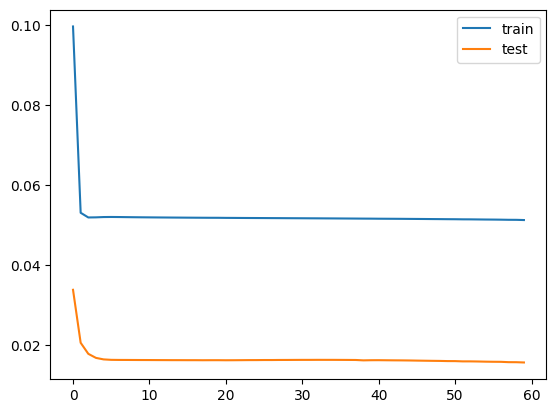

In [43]:
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [44]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_day*n_features))

14/14 [==============================] - 1s 8ms/step


In [45]:
# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -n_features:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

In [46]:
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -n_features:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

In [47]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.709


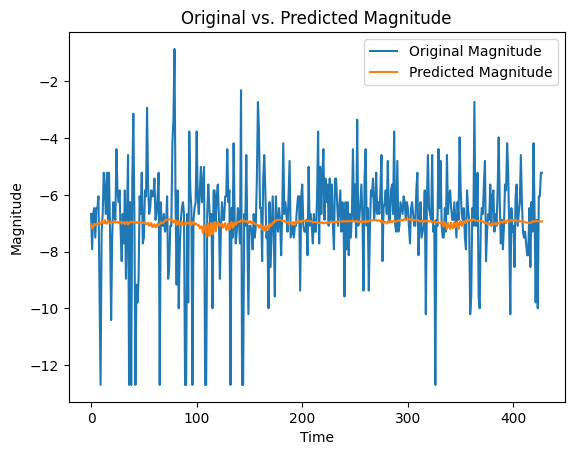

In [48]:
# Plot original magnitude and predicted magnitude
pyplot.plot(inv_y, label='Original Magnitude')
pyplot.plot(inv_yhat, label='Predicted Magnitude')
pyplot.xlabel('Time')
pyplot.ylabel('Magnitude')
pyplot.title('Original vs. Predicted Magnitude')
pyplot.legend()
pyplot.show()
